In [1]:
import os
import json
import csv
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2 as cv
from triplet_utils_test import *
import random
random.seed(100)
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

In [2]:
with open(os.path.join(data_path, "2DInstances.txt")) as f:
            reader = csv.reader(f, delimiter='\t')
            next(reader)
            instances = [i for i in reader]

In [3]:
nb_instances = len(instances)
print(f"Number of instances: {nb_instances}")

Number of instances: 1129


In [4]:
len(instances[0])

21

## Encoding Dataset

In [5]:
class EncodingDataset(torch.utils.data.Dataset):
    def __init__(self, instances, transform=None):
        self.transform = transform
        self.instances = instances
        self.size = len(self.instances)

    def __getitem__(self, idx):
        instance = load_instance(self.instances[idx], self.transform)

        return instance

    def __len__(self):
        return self.size

In [6]:
test_dataset = EncodingDataset(instances, transform)

In [7]:
test_dataset.size

1129

In [8]:
batch_size = 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [9]:
batch = next(iter(test_loader))

In [10]:
batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'bbox': {'x': tensor([48]),
  'y': tensor([92]),
  'w': tensor([127]),
  'h': tensor([87])},
 'label': ['table'],
 'instance_id': tensor([5]),
 'reference': [

In [11]:
batch['image'].shape

torch.Size([1, 3, 224, 224])

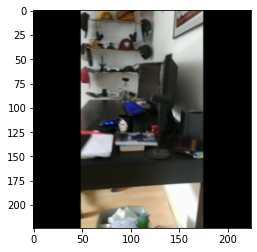

In [12]:
plt.imshow(batch['image'][0].permute(1,2,0).numpy())
plt.show()

In [13]:
x = batch["bbox"]["x"][0]
y = batch["bbox"]["y"][0]
w = batch["bbox"]["w"][0]
h = batch["bbox"]["h"][0]
# crop image along each channel
img = batch["image"][:, :, y:y+h, x:x+w]

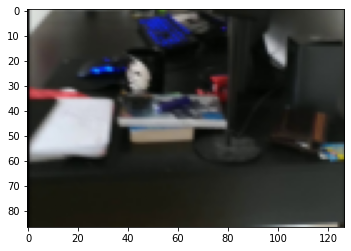

In [14]:
plt.imshow(img[0].permute(1,2,0).numpy())
plt.show()

In [15]:
labels = []
for batch in tqdm(test_loader):
    labels.append(batch['label'][0]+'__'+batch['reference'][0])

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1129/1129 [00:48<00:00, 23.17it/s]


In [16]:
len(labels)

1129

In [17]:
nb_labels = len(pd.Series(labels).unique())
nb_labels

32

## Open partition dictionaries

In [18]:
import pickle
from pathlib import Path

In [19]:
dict_path = "./saved_dict"
Path(dict_path).mkdir(parents=True, exist_ok=True)

In [20]:
os.path.join(dict_path, "test")

'./saved_dict/test'

In [21]:
# Commenter ce code après la première exécution

data_dict = {}
for i in labels:
    data_dict[i] = []

for idx in range(len(instances)):
    data_dict[labels[idx]].append(idx)

for key in data_dict:
    random.shuffle(data_dict[key])

def partitionRankings(rawRatings, testPercent):
    howManyNumbers = int(round(testPercent*len(rawRatings)))
    shuffled = rawRatings[:]
    random.shuffle(shuffled)
    return shuffled[howManyNumbers:], shuffled[:howManyNumbers]

pourcentage_ref = 0.1
ref_dict = {i: [] for i in labels}
test_dict = {i: [] for i in labels}

for i in data_dict:
    L = data_dict[i]
    test_dict[i], ref_dict[i] = partitionRankings(L, pourcentage_ref)

with open(os.path.join(dict_path, "data_dict.pkl"), "wb") as f:
    pickle.dump(data_dict, f)
    
with open(os.path.join(dict_path, "ref_dict.pkl"), "wb") as f:
    pickle.dump(ref_dict, f)
    
with open(os.path.join(dict_path, "test_dict.pkl"), "wb") as f:
    pickle.dump(test_dict, f)

In [22]:
with open(os.path.join(dict_path, "data_dict.pkl"), "rb") as f:
    data_dict = pickle.load(f)
    
with open(os.path.join(dict_path, "ref_dict.pkl"), "rb") as f:
    ref_dict = pickle.load(f)

with open(os.path.join(dict_path, "test_dict.pkl"), "rb") as f:
    test_dict = pickle.load(f)

## Model

In [23]:
import torch
import torchvision.models as models

In [24]:
model = models.resnet50(pretrained=True)

In [25]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
batch_encoding = model(batch['image'])

In [27]:
model(img).shape

torch.Size([1, 1000])

In [28]:
len(batch_encoding)

1

In [29]:
batch_encoding.shape

torch.Size([1, 1000])

In [30]:
batch_encoding.shape[1]

1000

In [31]:
results = []
for batch in tqdm(test_loader):
    x = batch["bbox"]["x"][0]
    y = batch["bbox"]["y"][0]
    w = batch["bbox"]["w"][0]
    h = batch["bbox"]["h"][0]
    # crop image along each channel
    img = batch["image"][:, :, y:y+h, x:x+w]
    #img = batch["image"]
    encoding = model(img)
    results.append(encoding.reshape(encoding.shape[1]).cpu().detach().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1129/1129 [02:29<00:00,  7.54it/s]


In [32]:
results = np.array(results)

In [33]:
results.shape

(1129, 1000)

In [34]:
len(results)

1129

In [35]:
len(results[0])

1000

## PCA

In [36]:
from sklearn.decomposition import PCA

In [37]:
pca = PCA(n_components=0.9)

In [38]:
pca_results = pca.fit_transform(results)

In [39]:
pca_results

array([[-4.3264111e+01,  4.1223655e+00,  6.9846053e+00, ...,
        -7.3314857e-01,  1.9944491e+00,  9.0065932e-01],
       [-2.1368376e+01,  5.3630561e-01,  1.1901797e+01, ...,
         1.0867977e+00, -7.3402166e-02, -3.9011335e+00],
       [-1.2229418e+00,  1.5230513e+01,  1.7919512e+01, ...,
        -4.9922556e-01,  8.5637665e-01, -2.0601435e+00],
       ...,
       [ 4.5495400e+00, -8.8159027e+00,  5.2575927e+00, ...,
        -1.5021619e+00,  2.3146548e+00,  3.2776363e+00],
       [ 7.8420639e+00, -2.7712696e+00,  5.3788428e+00, ...,
        -5.3859706e+00, -3.0406921e+00,  2.7293840e-02],
       [-2.1292872e+00, -1.3052084e+01, -2.2616148e+00, ...,
        -5.9535012e+00, -3.4168942e+00,  2.3955686e-02]], dtype=float32)

In [40]:
pca.explained_variance_ratio_

array([0.153396  , 0.08174638, 0.07307716, 0.06047259, 0.05326382,
       0.0455318 , 0.03311973, 0.02955127, 0.02816861, 0.02496291,
       0.02112084, 0.0188302 , 0.01673546, 0.01560757, 0.01378559,
       0.01315034, 0.0126209 , 0.01159745, 0.01096119, 0.0100755 ,
       0.00971907, 0.0090881 , 0.00890047, 0.0085334 , 0.00800744,
       0.00751529, 0.00708449, 0.00680714, 0.00664685, 0.00581751,
       0.00568265, 0.00543041, 0.00521154, 0.00509936, 0.00474807,
       0.00462226, 0.00443683, 0.00426913, 0.0040645 , 0.00404611,
       0.00395928, 0.00388177, 0.00380997, 0.00359046, 0.00352204,
       0.00325217, 0.00321532, 0.00307134, 0.00300571, 0.00289095,
       0.0028581 , 0.00268998, 0.00264221, 0.0025516 , 0.002506  ],
      dtype=float32)

In [41]:
len(pca_results)

1129

In [42]:
len(pca_results[:,0])

1129

In [43]:
pca_df = pd.DataFrame()

In [44]:
pca_df['x'] = pca_results[:,0]
pca_df['y'] = pca_results[:,1]
pca_df['labels']=labels

In [45]:
pca_df = pca_df .sort_values(by=['labels'])

In [46]:
pca_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129 entries, 689 to 1128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1129 non-null   float32
 1   y       1129 non-null   float32
 2   labels  1129 non-null   object 
dtypes: float32(2), object(1)
memory usage: 26.5+ KB


In [47]:
pca_df.head()

,x,y,labels
689,-11.115324,-17.084478,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
685,14.818276,4.292902,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
687,15.994392,-3.673095,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
688,10.891710,-2.209585,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
690,1.541944,-20.625233,armchair__7747a506-9431-24e8-87d9-37a5654d41f4


In [48]:
import seaborn as sns

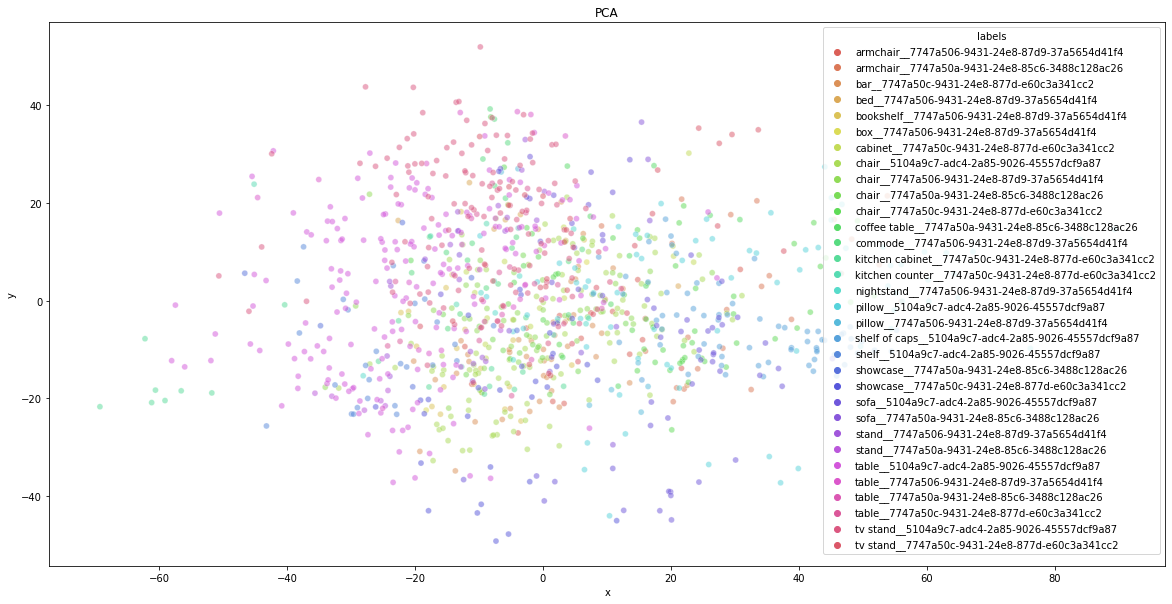

In [49]:
plt.figure(figsize=(20,10))
sns.scatterplot(
    x="x", y="y",
    hue="labels",
    palette=sns.color_palette("hls", nb_labels),
    data=pca_df,
    legend="full",
    alpha=0.5
)
plt.title('PCA')
plt.show()

## t-SNE

In [50]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, learning_rate='auto',init='random')

In [51]:
tsne_results = tsne.fit_transform(results)

In [52]:
tsne_df = pd.DataFrame()

In [53]:
tsne_df['x'] = tsne_results[:,0]
tsne_df['y'] = tsne_results[:,1]
tsne_df['labels']=labels

In [54]:
tsne_df = tsne_df.sort_values(by=['labels'])

In [55]:
tsne_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129 entries, 689 to 1128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1129 non-null   float32
 1   y       1129 non-null   float32
 2   labels  1129 non-null   object 
dtypes: float32(2), object(1)
memory usage: 26.5+ KB


In [56]:
tsne_df.head()

,x,y,labels
689,9.823044,3.805212,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
685,2.586396,-18.455441,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
687,2.572394,-18.974121,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
688,2.502565,-19.597523,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
690,-16.118521,-36.252945,armchair__7747a506-9431-24e8-87d9-37a5654d41f4


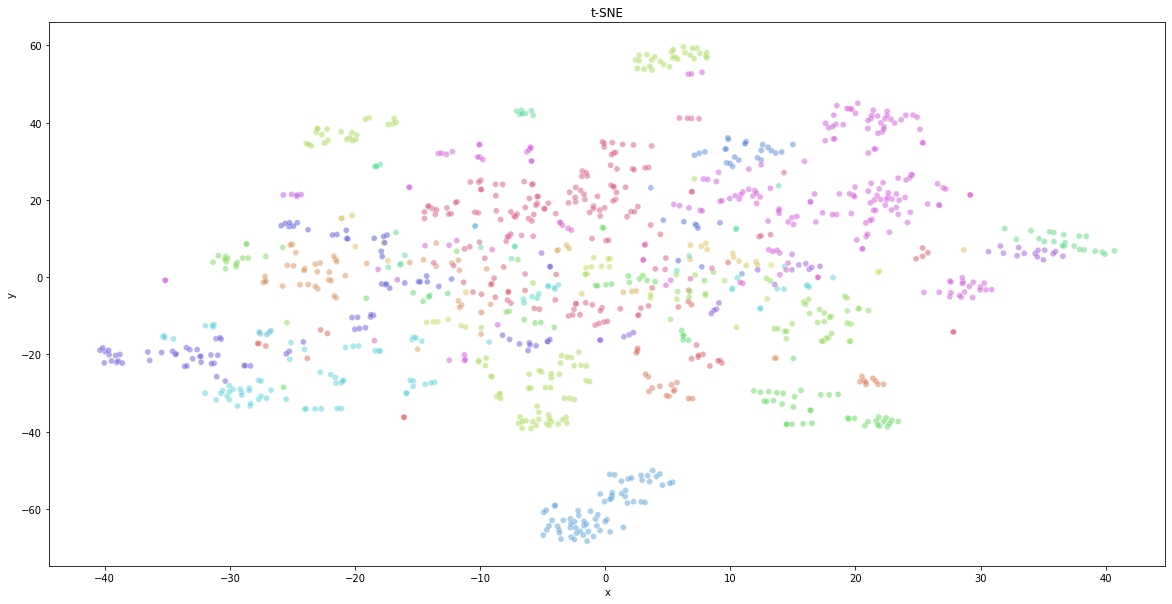

In [57]:
plt.figure(figsize=(20,10))
sns.scatterplot(
    x="x", y="y",
    hue="labels",
    palette=sns.color_palette("hls", nb_labels),
    data=tsne_df,
    legend="full",
    alpha=0.5
)
plt.title('t-SNE')
plt.legend([],[], frameon=False)
plt.show()

## UMAP

In [58]:
import umap.umap_ as umap

In [59]:
reducer = umap.UMAP()

In [60]:
umap_results = reducer.fit_transform(results)

In [61]:
umap_results

array([[-3.713482 ,  3.4992144],
       [-1.2759447,  2.3146188],
       [-0.8424851,  2.0817487],
       ...,
       [ 1.1823177,  2.4532673],
       [ 1.0452853,  2.3116932],
       [ 1.1688751,  2.2521634]], dtype=float32)

In [62]:
umap_df = pd.DataFrame()

In [63]:
umap_df['x'] = umap_results[:,0]
umap_df['y'] = umap_results[:,1]
umap_df['labels']=labels

In [64]:
umap_df = umap_df.sort_values(by=['labels'])

In [65]:
umap_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1129 entries, 689 to 1128
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1129 non-null   float32
 1   y       1129 non-null   float32
 2   labels  1129 non-null   object 
dtypes: float32(2), object(1)
memory usage: 26.5+ KB


In [66]:
umap_df.head()

,x,y,labels
689,0.331892,3.558980,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
685,2.279421,1.274951,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
687,2.372244,1.258774,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
688,2.378075,1.300816,armchair__7747a506-9431-24e8-87d9-37a5654d41f4
690,2.705683,1.598607,armchair__7747a506-9431-24e8-87d9-37a5654d41f4


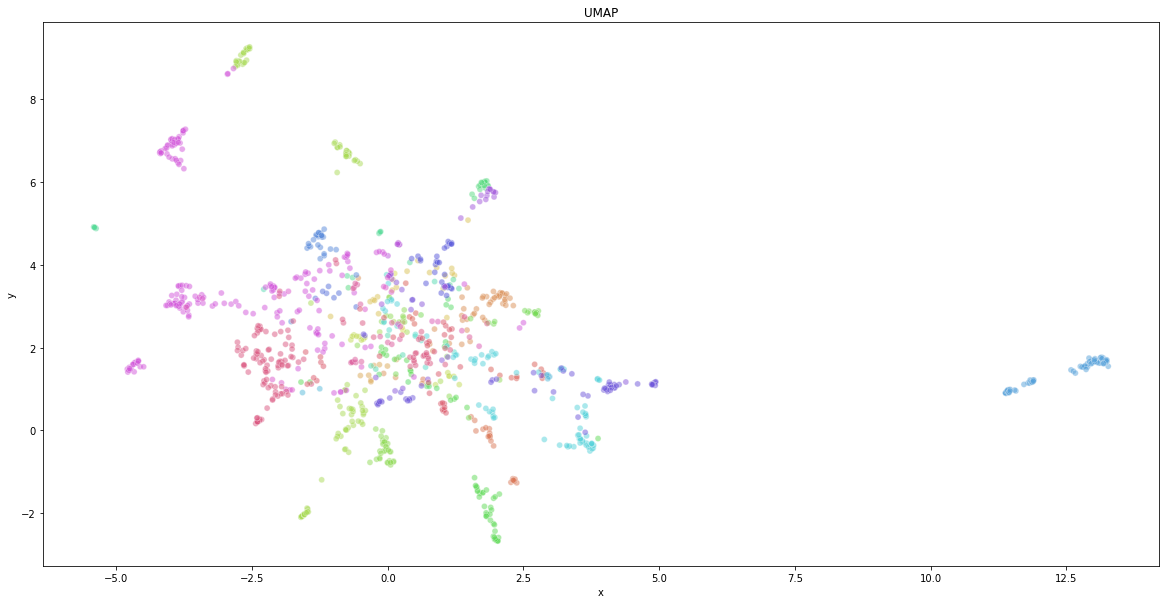

In [67]:
plt.figure(figsize=(20,10))
sns.scatterplot(
    x="x", y="y",
    hue="labels",
    palette=sns.color_palette("hls", nb_labels),
    data=umap_df,
    legend="full",
    alpha=0.5
)
plt.title('UMAP')
plt.legend([],[], frameon=False)
plt.show()

## k Nearest Neighbors

In [68]:
# Reference
ref_labels = []
ref_encodings = []
ref_idx = []
for k, v in tqdm(ref_dict.items()):
    for i in range(len(v)):
        ref_labels.append(k)
        ref_encodings.append(results[v[i]])
        ref_idx.append(v[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 51881.61it/s]


In [69]:
# Test
test_labels = []
test_encodings = []
test_idx = []
for k, v in tqdm(test_dict.items()):
    for i in range(len(v)):
        test_labels.append(k)
        test_encodings.append(results[v[i]])
        test_idx.append(v[i])

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 22199.43it/s]


In [70]:
len(ref_encodings), len(test_encodings)

(113, 1016)

In [71]:
from sklearn.neighbors import KNeighborsClassifier

In [72]:
for i in [1, 2, 5, 10, 20, 50]:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(ref_encodings, ref_labels)
    score = knn.score(test_encodings, test_labels)
    print("For " + str(i) + " neighbors, score of " + str(score))

For 1 neighbors, score of 0.6446850393700787
For 2 neighbors, score of 0.5511811023622047
For 5 neighbors, score of 0.5364173228346457
For 10 neighbors, score of 0.5127952755905512
For 20 neighbors, score of 0.4645669291338583
For 50 neighbors, score of 0.28051181102362205


## Testing on a random query

In [73]:
query_idx = random.randint(0, len(test_idx))
query_instance_idx = test_idx[query_idx]
query_encoding = test_encodings[query_idx]
query_label = test_labels[query_idx]
query_instance_idx

546

In [74]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=2, radius=0.4)
neigh.fit(ref_encodings)

NearestNeighbors(n_neighbors=2, radius=0.4)

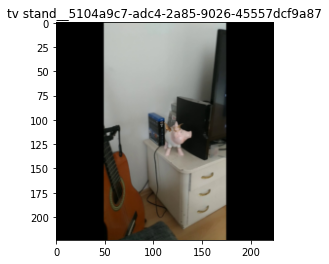

In [75]:
my_loaded_instance = load_instance(instances[query_instance_idx], transform)
plt.imshow(my_loaded_instance["image"].permute(1,2,0).numpy())
plt.title(query_label)
plt.show()

In [76]:
result = neigh.kneighbors([query_encoding], 2, return_distance=False)
result

array([[30, 31]])

In [77]:
result_instance_idx = ref_idx[result[0][0]]
result_label = ref_labels[result[0][0]]
result_instance_idx

557

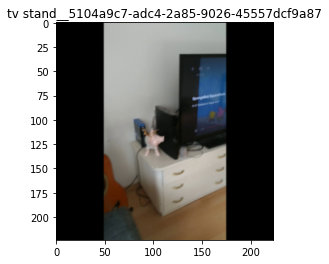

In [78]:
my_loaded_instance = load_instance(instances[ref_idx[result[0][0]]], transform)
plt.imshow(my_loaded_instance["image"].permute(1,2,0).numpy())
plt.title(result_label)
plt.show()

## Manual score

In [79]:
len(ref_labels), len(ref_encodings)

(113, 113)

In [80]:
def reid_score(k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(ref_encodings)
    score = 0
    for i in range(len(test_encodings)):
        query_label = test_labels[i]
        query_encoding = test_encodings[i]
        results = neigh.kneighbors([query_encoding], k, return_distance=False)
        matches_idx = results[0]
        for j in matches_idx:
            match_label = ref_labels[j]
            if match_label == query_label:
                score += 1
                break
    score /= len(test_encodings)
    return score

In [81]:
for i in [1, 2, 5, 10, 20, 50]:
    print(f"rank({i}) = {reid_score(i)}")

rank(1) = 0.6446850393700787
rank(2) = 0.7155511811023622
rank(5) = 0.8169291338582677
rank(10) = 0.8779527559055118
rank(20) = 0.9281496062992126
rank(50) = 0.9645669291338582


In [82]:
def map(k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(ref_encodings)
    mapk = 0
    for i in range(len(test_encodings)):
        query_label = test_labels[i]
        query_encoding = test_encodings[i]
        apk = 0
        results = neigh.kneighbors([query_encoding], k, return_distance=False)
        matches_idx = results[0]
        nb_true_matches = 0
        for idj, j in enumerate(matches_idx):
            if ref_labels[j] == query_label:
                nb_true_matches += 1
                apk += nb_true_matches / (idj+1)
        if nb_true_matches != 0:
            apk /= nb_true_matches
        mapk += apk
    mapk /= len(test_encodings)
    return mapk

In [83]:
for i in [1, 2, 5, 10, 20, 50]:
    print(f"mAP({i}) = {map(i)}")

mAP(1) = 0.6446850393700787
mAP(2) = 0.6801181102362205
mAP(5) = 0.6759746828521449
mAP(10) = 0.6247453124039054
mAP(20) = 0.5643932442952418
mAP(50) = 0.4727434258512269


## Results

#### Cropped dataset

<table><tr><th> Models <th><th> ResNet-18 <th><th> ResNet-34 <th><th> ResNet-50 <th><th> WideResNet-50 <th><tr>
<tr><td> Rank 1 <td><td> 58.07%  <td><td> 64.37% <td><td> 64.47% <td><td> 62.30% <td><tR>
<table>


#### Uncropped dataset

<table><tr><th> Models <th><th> ResNet-18 <th><th> ResNet-34 <th><th> ResNet-50 <th><th> WideResNet-50 <th><tr>
<tr><td> Rank 1 <td><td> 67.12%  <td><td> 65.64% <td><td> 66.14% <td><td> 64.04% <td><tR>
<table>